In [1]:
!python3 --version
!python --version
!conda --version
!conda env list
!pip --version
!which conda
!conda list
!which pip

import glob
import pickle

import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from imageio import imread, mimwrite
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS

from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv1D
from lcapt.metric import compute_frac_active, compute_l1_sparsity, compute_l2_error
from lcapt.preproc import make_unit_var, make_zero_mean

Python 3.8.12
Python 3.8.12
conda 4.13.0
# conda environments:
#
base                  *  /home/gonz495/miniconda3
dff_env                  /home/gonz495/miniconda3/envs/dff_env
lca_env                  /home/gonz495/miniconda3/envs/lca_env
nengo_env                /home/gonz495/miniconda3/envs/nengo_env

pip 19.3.1 from /usr/local/lib/python2.7/dist-packages/pip (python 2.7)
/home/gonz495/miniconda3/bin/conda
# packages in environment at /home/gonz495/miniconda3:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             5.1                       1_gnu  
absl-py                   1.0.0                    pypi_0    pypi
aedat                     1.2.2                    pypi_0    pypi
appdirs                   1.4.4              pyhd3eb1b0_0  
argon2-cffi               21.3.0                   pypi_0    pypi
argon2-cffi-bindings      21.2.0                   pypi_0    pypi
astroid           

/usr/local/bin/pip


In [2]:
pickle.HIGHEST_PROTOCOL = 4
dff_df = pd.read_hdf("../data/V1 Responses/dff.h5")

In [4]:
print(dff_df["frame"].max())
print(dff_df["session_type"].unique())
print(len(dff_df.index[dff_df["stimulus"] == "natural_movie_three"].tolist()))
print(dff_df.index[dff_df["stimulus"] == "natural_movie_three"].tolist())

3599.0
['three_session_B' 'three_session_A' 'three_session_C' 'three_session_C2']
36000
[102127, 102128, 102129, 102130, 102131, 102132, 102133, 102134, 102135, 102136, 102137, 102138, 102139, 102140, 102141, 102142, 102143, 102144, 102145, 102146, 102147, 102148, 102149, 102150, 102151, 102152, 102153, 102154, 102155, 102156, 102157, 102158, 102159, 102160, 102161, 102162, 102163, 102164, 102165, 102166, 102167, 102168, 102169, 102170, 102171, 102172, 102173, 102174, 102175, 102176, 102177, 102178, 102179, 102180, 102181, 102182, 102183, 102184, 102185, 102186, 102187, 102188, 102189, 102190, 102191, 102192, 102193, 102194, 102195, 102196, 102197, 102198, 102199, 102200, 102201, 102202, 102203, 102204, 102205, 102206, 102207, 102208, 102209, 102210, 102211, 102212, 102213, 102214, 102215, 102216, 102217, 102218, 102219, 102220, 102221, 102222, 102223, 102224, 102225, 102226, 102227, 102228, 102229, 102230, 102231, 102232, 102233, 102234, 102235, 102236, 102237, 102238, 102239, 102240,

In [20]:
dff_df

,frame,repeat,stimulus,session_type,orientation,spatial_frequency,phase,541483910_540168835,541483918_540168835,541483922_540168835,...,589174806_511510911,589174833_511510911,589175052_511510911,589175071_511510911,589175092_511510911,589175111_511510911,589175127_511510911,589175143_511510911,589175164_511510911,589175188_511510911
0,0.0,0.0,natural_movie_one,three_session_B,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045074,0.171143,0.181152,0.088745,0.071289,0.109192,NaN,0.255127,0.090149,NaN
1,1.0,0.0,natural_movie_one,three_session_B,NaN,NaN,NaN,NaN,NaN,NaN,...,0.033051,0.182251,0.136841,0.062805,0.056213,0.094971,NaN,0.181274,0.111023,NaN
2,2.0,0.0,natural_movie_one,three_session_B,NaN,NaN,NaN,NaN,NaN,NaN,...,0.029724,0.166382,0.090942,0.065491,0.059814,0.082947,NaN,0.115601,0.148560,NaN
3,3.0,0.0,natural_movie_one,three_session_B,NaN,NaN,NaN,NaN,NaN,NaN,...,0.044830,0.163452,0.078369,0.085571,0.093445,0.072876,NaN,0.085266,0.098816,NaN
4,4.0,0.0,natural_movie_one,three_session_B,NaN,NaN,NaN,NaN,NaN,NaN,...,0.048370,0.130371,0.049805,0.102844,0.129883,0.130981,NaN,0.053802,0.045868,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186837,NaN,48.3,static_gratings,three_session_B,0.0,0.08,0.50,NaN,NaN,NaN,...,0.044281,0.211792,0.181274,0.172119,0.528809,0.159668,NaN,0.147461,0.097107,NaN
186838,NaN,48.4,static_gratings,three_session_B,0.0,0.08,0.50,NaN,NaN,NaN,...,0.088135,0.189331,0.208984,0.124084,0.491455,0.240356,NaN,0.107483,0.124817,NaN
186839,NaN,48.7,static_gratings,three_session_B,0.0,0.02,0.25,NaN,NaN,NaN,...,0.044891,0.104126,0.118042,0.035370,0.050903,0.079956,NaN,0.110291,0.195801,NaN
186840,NaN,48.7,static_gratings,three_session_B,90.0,0.16,0.50,NaN,NaN,NaN,...,0.059723,0.182617,0.080566,0.123962,0.134277,0.122192,NaN,0.214722,0.115234,NaN


In [ ]:
dff_sample0 = dff_df[["frame", "repeat", "stimulus", "session_type", "589174806_511510911"]]
dff_sample0_rep0_movie1 = dff_sample0.where(
    (dff_sample0["repeat"] == 0)
    & (dff_sample0["stimulus"] == "natural_movie_three")
    & (dff_sample0["session_type"] == "three_session_B")
).dropna()
dff_sample0_rep0_movie1["589174806_511510911"]

In [3]:
BATCH_SIZE = 64
EPOCHS = 
FEATURES = 64
KERNEL_SIZE = 256
LAMBDA = 0.5
LCA_ITERS = 1000
PRINT_FREQ = 10
STRIDE = 4
TAU = 200

In [4]:
lca = LCAConv1D(
    FEATURES,
    1,
    "./dff_traces",
    KERNEL_SIZE,
    STRIDE,
    pad="valid",
    tau=TAU,
    lambda_=LAMBDA,
    input_zero_mean=False,
    input_unit_var=False,
    return_all=False,
    track_metrics=False,
)
if torch.cuda.is_available():
    lca = nn.DataParallel(lca).cuda()

In [ ]:
v1_sparsity_distribution_list = []
v1_activity_distribution_list = []
v1_fraction_distribution_list = []

for epoch in range(EPOCHS):
    for batch_num, batch in enumerate(dataloader):
        batch = make_unit_var(make_zero_mean(batch))
        batch = batch.cuda()
        code = lca(batch)
        recon = lca.module.compute_recon(code, lca.module.weights)
        recon_error = batch - recon
        lca.module.update_weights(code, recon_error)
        if batch_num % PRINT_FREQ == 0:
            l1_sparsity = compute_l1_sparsity(code, lca.module.lambda_).item()
            l2_recon_error = compute_l2_error(batch, recon).item()
            total_energy = l2_recon_error + l1_sparsity
            print(
                f"L2 Recon Error: {round(l2_recon_error, 2)}; ",
                f"L1 Sparsity: {round(l1_sparsity, 2)}; ",
                f"Total Energy: {round(total_energy, 2)}",
            )
    torch.save(lca, f"../models/dffTraces_{epoch}.pth")

In [ ]:
# TRYOUTS FOR ALLEN VIDEO

In [ ]:
v1_sparsity_distribution_list = []
v1_activity_distribution_list = []
v1_fraction_distribution_list = []

for batch_num, windowed_frames_batch in enumerate(splitted6_wf):
    windowed_frames_batch = torch.unsqueeze(windowed_frames_batch, 1)
    windowed_frames_batch = windowed_frames_batch.cuda()
    windowed_frames_batch = make_unit_var(make_zero_mean(windowed_frames_batch))

    code = allen_lca(windowed_frames_batch)
    v1_activity_distribution_list.append(code)
    v1_fraction_distribution_list.append(compute_frac_active(code))
    v1_sparsity_distribution_list.append(compute_l1_sparsity(code, allen_lca.module.lambda_).item())

    recon = allen_lca.module.compute_recon(code, allen_lca.module.weights)
    recon_error = windowed_frames_batch - recon
    allen_lca.module.update_weights(code, recon_error)

    if batch_num % PRINT_FREQ == 0:
        l1_sparsity = compute_l1_sparsity(code, allen_lca.module.lambda_).item()
        l2_recon_error = compute_l2_error(windowed_frames_batch, recon).item()
        total_energy = l2_recon_error + l1_sparsity

        print(
            f"L2 Recon Error: {round(l2_recon_error, 2)}; ",
            f"L1 Sparsity: {round(l1_sparsity, 2)}; ",
            f"Total Energy: {round(total_energy, 2)}; ",
            f"acts_all: {code.shape}; ",
            f"batch_num: {batch_num}; ",
            f"nonzero_counter on activity: {torch.count_nonzero(code)}",
        )

torch.save(allen_lca, f"../models/save_allenMovieOne_batch{batch_split}.pth")

In [ ]:
weight_grid = make_feature_grid(lca.module.get_weights())
weight_grid.shape

In [ ]:
for i in range(15):
    plt.plot(weight_grid[i].cpu().numpy())
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
for i in range(15):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].plot((recon_error + recon)[i, 0].cpu().numpy())
    axs[1].plot(recon.cpu().numpy()[i, 0])
    axs[2].plot(recon_error[i, 0].cpu().numpy())
    axs[0].set_title("Input")
    axs[1].set_title("Reconstruction")
    axs[2].set_title("Input - Reconstruction")

    for ax in axs:
        ax.set_ylim(-3, 3)
        ax.grid()

    plt.show()
    plt.close()

In [ ]:
(acts != 0.0).float().mean().item()

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

torch.Size([140, 1, 7, 9, 9]) 
 torch.Size([140, 1, 7, 9, 9])
3D grid here
torch.Size([140, 1, 7, 9, 9]) 7 11
3D grid here
torch.Size([140, 1, 7, 9, 9]) 7 11
3D grid here
torch.Size([140, 1, 7, 9, 9]) 7 11
3D grid here
torch.Size([140, 1, 7, 9, 9]) 7 11


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


/home/gonz495/miniconda3/envs/lca_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  after removing the cwd from sys.path.


Computing Recon...
Plotting frame # 0 torch.Size([1, 1, 7, 160, 256])
Plotting frame # 1 torch.Size([1, 1, 7, 160, 256])
Plotting frame # 2 torch.Size([1, 1, 7, 160, 256])
Plotting frame # 3 torch.Size([1, 1, 7, 160, 256])
Plotting frame # 4 torch.Size([1, 1, 7, 160, 256])
Plotting frame # 5 torch.Size([1, 1, 7, 160, 256])
Plotting frame # 6 torch.Size([1, 1, 7, 160, 256])


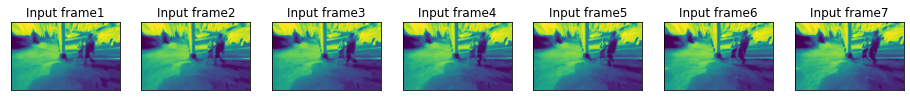

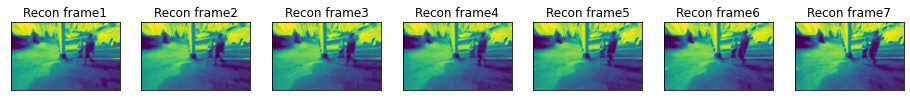

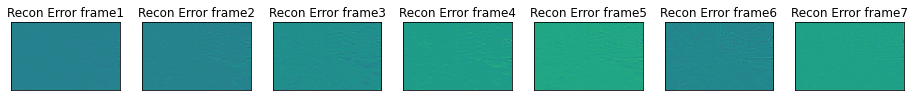

torch.Size([1, 140, 1, 80, 128]) torch.Size([140, 128])


,neuron,frequency
0,1,0.897139
1,2,1.176253
2,3,2.561646
3,4,0.980739
4,5,0.992757
...,...,...
123,124,1.138906
124,125,1.066664
125,126,1.487406
126,127,1.821588


<AxesSubplot:title={'center':'average sparsity: 1.2362972875125706'}, xlabel='neuron'>

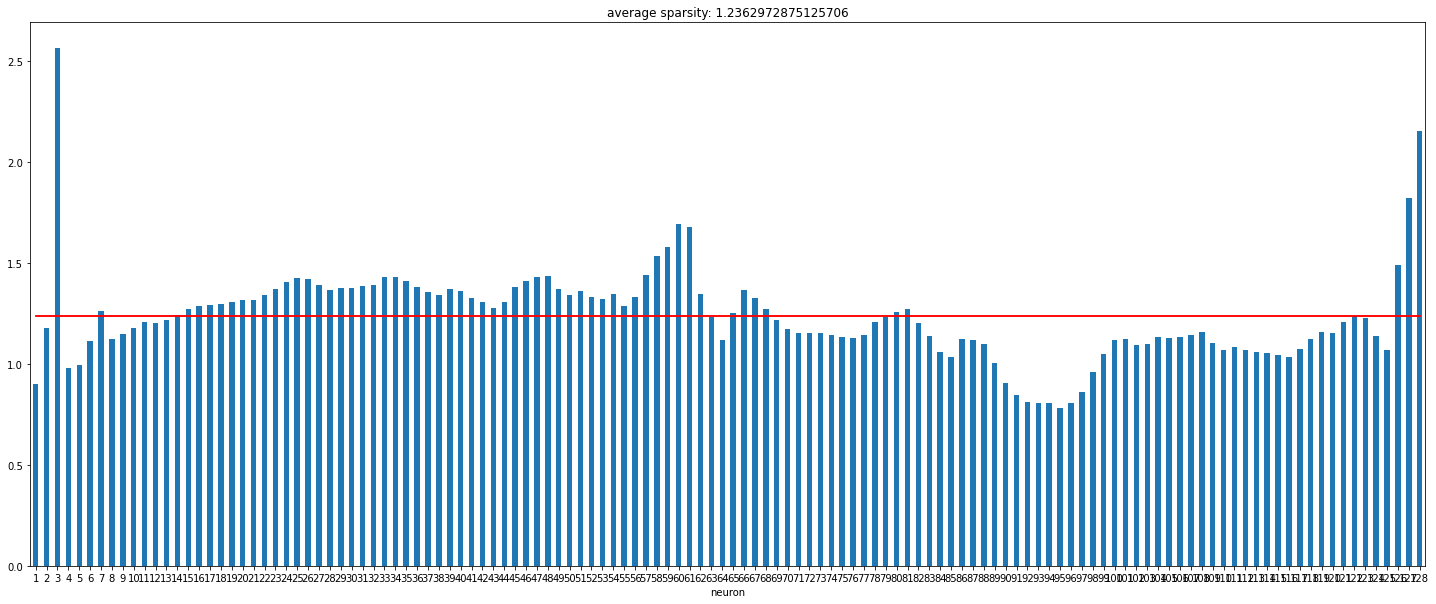

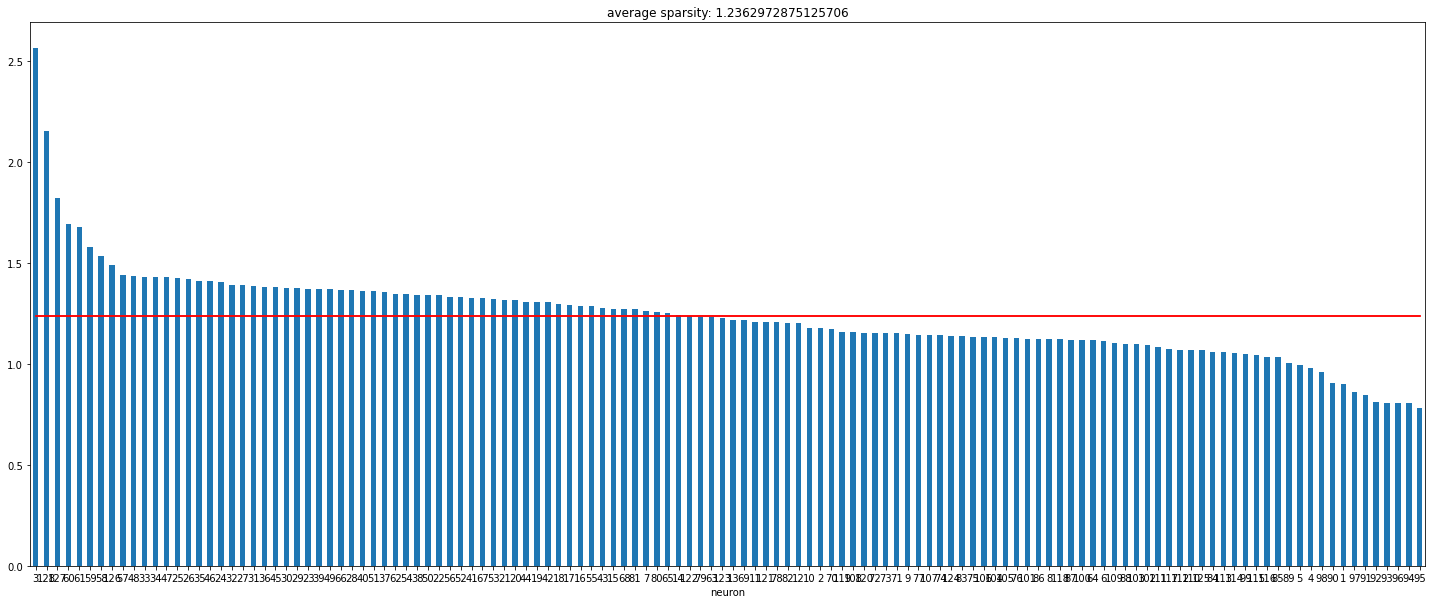

128